In [832]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib
%matplotlib inline
import seaborn as sns
import missingno as msno
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [833]:
!pip install missingno

### 결측치 점검

In [834]:
df_raw = pd.read_csv("C:\\Users\\user\\Desktop\\0822_H_data.csv")

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14956 entries, 0 to 14955
Columns: 254 entries, id to hm_01_rel_t
dtypes: float64(178), int64(74), object(2)
memory usage: 29.0+ MB


In [835]:
df = df_raw.drop(['emp_keep_a', 'hazard_phy_d','hazard_phy_a','hazard_phy_c','hazard_phy_e','hazard_phy_f','hazard_phy_g','hazard_phy_h', 'hazard_phy_i', 'ch_downsizing', 'job_c1_r', 'job_c1', 'emp_pay_type', 'skillmat', 'emp_comp_com_a','emp_comp_com_b','emp_comp_com_c','ch_ic','ch_restruct','wplace_sl','emp_noncon', 'wcomback'], axis = 1)

In [836]:
# 널값 개수와 비율 계산
null_summary = (
    df.isnull().sum()
      .to_frame("널값 개수")
      .assign(널값비율 = lambda x: (x["널값 개수"] / len(df_raw) * 100).round(2))
      .reset_index()
      .rename(columns={'index': '컬럼명'})
)

# 널값 있는 열만 필터링 & 비율 기준 내림차순 정렬
null_summary = (
    null_summary[null_summary["널값 개수"] > 0]
    .sort_values(by="널값비율", ascending=False)
    .reset_index(drop=True)
)

print(null_summary)

                  컬럼명  널값 개수  널값비율
0         comp_size_b    870  5.82
1        wtime_ftwork    584  3.90
2            emp_keep    581  3.88
3          emo_manual    307  2.05
4    wtime_resilience    279  1.87
..                ...    ...   ...
150       wsituation7      2  0.01
151      wsituation13      1  0.01
152            wstat1      1  0.01
153         winten2_a      2  0.01
154     wtime_length3      2  0.01

[155 rows x 3 columns]


In [837]:
# start 파일
# df.to_csv("2PD_v1_0822.csv", encoding="CP949")

### 중복 피쳐 삭제/8,9->결측치 수정

In [838]:
# 불필요한 피쳐 삭제하기 (14개)
df = df.drop(columns=["ptime_r", "stratification", "district", "household", "target", "mode", "hh_num", "eli_num", "hm_01_gender", "hm_01_year", "hm_01_estat", "hm_01_rel_t","wtime_week", "earning1_r"])

print(df)

              id burnout60  area  gender  age  wduration_y  earning1  \
0      1000042_1       lv1     1       1   49           10       500   
1      1000051_1       lv2     1       1   31            2       300   
2      1000056_1       lv1     1       1   32            2       300   
3      1000069_1       lv1     1       1   38            2       390   
4      1000069_2       lv1     1       2   37            5       330   
...          ...       ...   ...     ...  ...          ...       ...   
14951  2010124_1       lv1     7       1   37            6       450   
14952  2010133_1       lv2     7       2   46            3       230   
14953  2010134_2       lv1     7       2   34            5       320   
14954  2010137_1       lv1     7       1   57            5       450   
14955  2010137_2       lv1     7       2   29            3       350   

       earning2_r  wtime_r  woutside4_a  wtime_length5  age_group  \
0               6     40.0            1              2          4 

In [839]:
# 전처리: 8, 9 NULL (5개)
cols = ["hazard_erg_a", "hazard_erg_b", "hazard_erg_c", "hazard_erg_d", "hazard_erg_e"]

df[cols] = df[cols].replace([8, 9], pd.NA)

print(df['hazard_erg_a'].unique())
print(df['hazard_erg_b'].unique())
print(df['hazard_erg_c'].unique())
print(df['hazard_erg_d'].unique())
print(df['hazard_erg_e'].unique())


[6 2 1 7 5 4 3 <NA>]
[1 5 6 3 4 7 2 <NA>]
[ 7.  6.  2.  5.  4.  3.  1. nan]
[ 7.  2.  5.  4.  6.  3. nan  1.]
[ 7.  3.  5.  6.  4.  2.  1. nan]


In [840]:
# 잘못 변경된 변수명 복원
df.rename(columns={
    "wsituation": "wsituation8",
    "wsituation.1": "wsituation9",
    "disc": "disc9",
    "disc.1": "disc8"
}, inplace=True)

### 긍/부정 변경

In [841]:
df["wstat4"].head(10) 

0    2
1    2
2    2
3    3
4    5
5    5
6    5
7    5
8    5
9    5
Name: wstat4, dtype: int64

In [842]:
# 긍/부정 변경
# 5점 척도

cols = [
    "wstat4", "wstat6",
    "wwa1", "wwa2", "wwa3", "wwa4", "wwa5",
    "sleep1", "sleep2", "sleep3",
    "wsituation12", "wsituation14"
]

# 변환 딕셔너리 (5점 척도 역코딩)
reverse_map = {1: 5, 2: 4, 3: 3, 4: 2, 5: 1}

# 여러 열에 적용
for col in cols:
    df[col] = df[col].map(reverse_map).fillna(df[col])

df["wstat4"].head(10) 

0    4
1    4
2    4
3    3
4    1
5    1
6    1
7    1
8    1
9    1
Name: wstat4, dtype: int64

In [843]:
# 3점 척도 
cols_2 = [
   "heal_lim1"
]

# 변환 딕셔너리 (3점 척도 역코딩)
reverse_map = {1: 3, 2: 2, 3: 1}

# 여러 열에 적용
for col in cols_2:
    df[col] = df[col].map(reverse_map).fillna(df[col])


#%%
print(df.columns.tolist())
#%%
print(df[cols_2].head())
#%%
df["heal_lim1"].head(10) 
#%%


['id', 'burnout60', 'area', 'gender', 'age', 'wduration_y', 'earning1', 'earning2_r', 'wtime_r', 'woutside4_a', 'wtime_length5', 'age_group', 'emp_period_group', 'wtime_group', 'compsize_group', 'woutside_group', 'compsize_group_a', 'wday_week_group_a', 'woutside4_group_a', 'occ_t2_group_a', 'earning2_group_b', 'occ_group_a', 'emp_stat', 'emp_con_term', 'emp_keep', 'emp_own_mgmt', 'emp_fptime', 'emp_wage', 'emp_stat_sp', 'income_pos_a', 'income_pos_b', 'income_pos_c', 'income_pos_d', 'income_pos_e', 'income_pos_f', 'income_pos_g', 'income_pos_h', 'income_pos_i', 'income_pos_j', 'emp_place', 'emp_suggest_a', 'emp_suggest_b', 'emp_boss_gender', 'emp_manaqual_a', 'emp_manaqual_b', 'emp_manaqual_c', 'emp_manaqual_d', 'emp_manaqual_e', 'emp_comp_ass_a', 'emp_comp_ass_b', 'emp_comp_ass_c', 'emp_comp_ass_d', 'emp_comp_ass_e', 'emp_comp_ass_f', 'emp_rep', 'emp_winflu_a', 'emp_winflu_b', 'emp_winflu_c', 'emp_tra_b', 'emp_tra_c', 'emp_tra_d', 'wsector', 'comp_size_a', 'comp_size_b', 'comp_female

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
8    1.0
9    1.0
Name: heal_lim1, dtype: float64

In [844]:
# 4점 척도
cols_1 = [
    "imte1", "imte2", "imte3", "imte4", "imte5",
]

# 변환 딕셔너리 (4점 척도 역코딩)
reverse_map = {1: 4, 2: 3, 3: 2, 4: 1}

# 여러 열에 적용
for col in cols_1:
    df[col] = df[col].map(reverse_map).fillna(df[col])


#%%
print(df.columns.tolist())
#%%
print(df[cols_1].head())
#%%
df["imte1"].head(10) 
#%%

['id', 'burnout60', 'area', 'gender', 'age', 'wduration_y', 'earning1', 'earning2_r', 'wtime_r', 'woutside4_a', 'wtime_length5', 'age_group', 'emp_period_group', 'wtime_group', 'compsize_group', 'woutside_group', 'compsize_group_a', 'wday_week_group_a', 'woutside4_group_a', 'occ_t2_group_a', 'earning2_group_b', 'occ_group_a', 'emp_stat', 'emp_con_term', 'emp_keep', 'emp_own_mgmt', 'emp_fptime', 'emp_wage', 'emp_stat_sp', 'income_pos_a', 'income_pos_b', 'income_pos_c', 'income_pos_d', 'income_pos_e', 'income_pos_f', 'income_pos_g', 'income_pos_h', 'income_pos_i', 'income_pos_j', 'emp_place', 'emp_suggest_a', 'emp_suggest_b', 'emp_boss_gender', 'emp_manaqual_a', 'emp_manaqual_b', 'emp_manaqual_c', 'emp_manaqual_d', 'emp_manaqual_e', 'emp_comp_ass_a', 'emp_comp_ass_b', 'emp_comp_ass_c', 'emp_comp_ass_d', 'emp_comp_ass_e', 'emp_comp_ass_f', 'emp_rep', 'emp_winflu_a', 'emp_winflu_b', 'emp_winflu_c', 'emp_tra_b', 'emp_tra_c', 'emp_tra_d', 'wsector', 'comp_size_a', 'comp_size_b', 'comp_female

0    3.0
1    3.0
2    3.0
3    1.0
4    2.0
5    2.0
6    2.0
7    3.0
8    2.0
9    2.0
Name: imte1, dtype: float64

### 연속형 변수 재범주화

In [845]:
df['heal_abs1'].value_counts()

heal_abs1
0.0      14127
2.0        181
1.0        127
3.0        113
5.0         80
7.0         65
10.0        31
8.0         25
4.0         24
6.0         10
15.0         9
20.0         6
30.0         6
14.0         5
13.0         5
12.0         4
90.0         3
60.0         2
11.0         1
180.0        1
120.0        1
50.0         1
21.0         1
Name: count, dtype: int64

In [846]:
# 범주화 

df["heal_abs1_group"] = np.where(df["heal_abs1"] == 0, 0, 1)
df['heal_abs1_group'] = df['heal_abs1_group'].map({0: 1, 1: 2})
#%%
print(df["heal_abs1_group"].head())
#%%
df["heal_abs1_group"].value_counts()


0    1
1    1
2    1
3    1
4    1
Name: heal_abs1_group, dtype: int64


heal_abs1_group
1    14127
2      829
Name: count, dtype: int64

In [847]:
# 구간 (0~60, 61~120, 121 이상)
bins = [0, 60, 120, float("inf")]
labels = [1, 2, 3]

df["ctime_group"] = pd.cut(df["ctime"], bins=bins, labels=labels, right=True)
#%%
print(df["ctime_group"].head())
#%%
df["ctime_group"].value_counts()
#%%

0      1
1      1
2      1
3      2
4    NaN
Name: ctime_group, dtype: category
Categories (3, int64): [1 < 2 < 3]


ctime_group
1    12582
2     1150
3      328
Name: count, dtype: int64

In [848]:
# 파생변수로 대체된 컬럼 삭제
df = df.drop(['heal_abs1','ctime'], axis = 1)
print(df)

              id burnout60  area  gender  age  wduration_y  earning1  \
0      1000042_1       lv1     1       1   49           10       500   
1      1000051_1       lv2     1       1   31            2       300   
2      1000056_1       lv1     1       1   32            2       300   
3      1000069_1       lv1     1       1   38            2       390   
4      1000069_2       lv1     1       2   37            5       330   
...          ...       ...   ...     ...  ...          ...       ...   
14951  2010124_1       lv1     7       1   37            6       450   
14952  2010133_1       lv2     7       2   46            3       230   
14953  2010134_2       lv1     7       2   34            5       320   
14954  2010137_1       lv1     7       1   57            5       450   
14955  2010137_2       lv1     7       2   29            3       350   

       earning2_r  wtime_r  woutside4_a  wtime_length5  age_group  \
0               6     40.0            1              2          4 

### 중복 피쳐 삭제

In [849]:
# 1차 프로젝트에서 파생변수 만들었던 변수 삭제
df = df.drop(['occ', 'occ2', 'age', 'earning2_r', 'wday_week', 'woutside4', 'wtime_r', 'wduration_y'], axis = 1)

### 상관관계 매트릭스 분석

In [850]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df.corr(numeric_only=True)
# sns.heatmap(corr, cmap="coolwarm", center=0)
# plt.show()

In [851]:
# 상관계수 절댓값이 0.8 이상인 쌍만 추출 (자기 자신 제외)
high_corr = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))  
        .stack()                                               
        .reset_index()
        .rename(columns={'level_0': '변수1', 'level_1': '변수2', 0: '상관계수'})
)

# 조건 필터링
high_corr = high_corr[high_corr['상관계수'].abs() >= 0.8]

print(high_corr.sort_values(by='상관계수', ascending=False).head(20))

                    변수1           변수2      상관계수
10060       comp_size_b  comp_sizeb_r  1.000000
10059       comp_size_b  comp_sizea_r  1.000000
15552             disc3         disc4  0.988628
20492               ind          ind2  0.985571
15452             disc2         disc3  0.984493
15453             disc2         disc4  0.982562
1780     compsize_group  comp_sizeb_r  0.975227
1636     compsize_group   comp_size_b  0.969841
15351             disc8         disc2  0.962101
15353             disc8         disc4  0.956305
15352             disc8         disc3  0.954483
15249             disc7         disc8  0.944109
15250             disc7         disc2  0.920967
20499      comp_sizea_r  comp_sizeb_r  0.920086
2165   compsize_group_a  comp_sizeb_r  0.916659
15252             disc7         disc4  0.913893
15251             disc7         disc3  0.913422
1779     compsize_group  comp_sizea_r  0.910546
2021   compsize_group_a   comp_size_b  0.893071
15146             disc6         disc7  0

In [852]:
unique_vars = set(high_corr['변수1']).union(set(high_corr['변수2']))
print("조건 충족하는 변수 개수:", len(unique_vars))
print("변수 목록:", unique_vars)

조건 충족하는 변수 개수: 23
변수 목록: {'disc6', 'woutside4_a', 'comp_size_b', 'winten3_c', 'compsize_group', 'earning1', 'winten3_d', 'disc3', 'disc7', 'comp_sizea_r', 'disc4', 'disc8', 'woutside_group', 'compsize_group_a', 'comp_sizeb_r', 'winten2_b', 'earning2_group_b', 'decla_b', 'ind', 'winten2_a', 'disc2', 'decla_a', 'ind2'}


In [853]:
# 상관분석 결과 필요없는 변수 삭제
df = df.drop(['comp_size_b', 'comp_sizea_r', 'comp_sizeb_r', 'ind', 'ind2', 'earning1', 'woutside4_a'], axis = 1)

In [854]:
# disc 변수 : 차별 유/무로 파생변수 생성
cols = ['disc1','disc2','disc3','disc4','disc5',
        'disc6','disc7','disc8','disc9','disc10','disc11']

# 하나라도 1이 있으면 1, 아니면 0
df['disc_group'] = (df[cols].sum(axis=1) > 0).astype(int)

df['disc_group'] = df['disc_group'].map({0: 1, 1: 2})

print(df['disc_group'].unique())

[2 1]


In [855]:
# decla 변수 : 작업선택의 가능성 유/무로 파생변수 생성
cols = ['decla_a','decla_b']

# 하나라도 1이 있으면 1, 아니면 0
df['decla_group'] = (df[cols].sum(axis=1) > 0).astype(int)

df['decla_group'] = df['decla_group'].map({0: 1, 1: 2})

print(df['decla_group'].unique())

[2 1]


In [856]:
# winten2 변수 : 작업 강도가 세다로 파생변수 생성(7점 척도)
cols = ['winten2_a','winten2_b']

# 둘 중 하나라도 있으면 최대값
df['winten2_group'] = df[cols].max(axis=1, skipna=True)

print(df['winten2_group'].unique())

[ 5.  6.  7.  1.  4.  3.  2. nan]


In [857]:
# winten3 변수 : 작업선택의 가능성 유/무로 파생변수 생성
cols = ['winten3_c','winten3_d', 'winten3_a', 'winten3_b', 'winten3_e']

# 하나라도 1이 있으면 1, 아니면 0
df['winten3_group'] = (df[cols].sum(axis=1) > 0).astype(int)

df['winten3_group'] = df['winten3_group'].map({0: 1, 1: 2})

print(df['winten3_group'].unique())

[2 1]


In [858]:
# 파생변수로 대체된 컬럼 삭제
df = df.drop(['disc1','disc2','disc3','disc4','disc5',
              'disc6','disc7','disc8','disc9','disc10','disc11','decla_a','decla_b','winten2_a','winten2_b', 'winten3_c','winten3_d', 'winten3_a', 'winten3_b', 'winten3_e'], axis = 1)

### 조작적 정의에 사용된 변수 삭제

In [859]:
df = df.drop(['weng1','weng2','weng3','wsituation14','wwa2','sleep2','sleep3','weng4','weng5','wsituation1','wstat4','wsituation2','wsituation12', 'wsituation10','wsituation9'], axis = 1)

### 널값 삭제

In [860]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14956 entries, 0 to 14955
Columns: 172 entries, id to winten3_group
dtypes: category(1), float64(133), int64(34), object(4)
memory usage: 19.5+ MB


In [861]:
df_new = df.dropna()

In [862]:
df_new

,id,burnout60,area,gender,wtime_length5,age_group,emp_period_group,wtime_group,compsize_group,woutside_group,compsize_group_a,wday_week_group_a,woutside4_group_a,occ_t2_group_a,earning2_group_b,occ_group_a,emp_stat,emp_con_term,emp_keep,emp_own_mgmt,emp_fptime,emp_wage,emp_stat_sp,income_pos_a,income_pos_b,income_pos_c,income_pos_d,income_pos_e,income_pos_f,income_pos_g,income_pos_h,income_pos_i,income_pos_j,emp_place,emp_suggest_a,emp_suggest_b,emp_boss_gender,emp_manaqual_a,emp_manaqual_b,emp_manaqual_c,emp_manaqual_d,emp_manaqual_e,emp_comp_ass_a,emp_comp_ass_b,emp_comp_ass_c,emp_comp_ass_d,emp_comp_ass_e,emp_comp_ass_f,emp_rep,emp_winflu_a,emp_winflu_b,emp_winflu_c,emp_tra_b,emp_tra_c,emp_tra_d,wsector,comp_size_a,comp_female,comp_sjob,ch_tech,ch_me,ch_ps,imte1,imte2,imte3,imte4,imte5,safeinform,wsituation3,wsituation4,wsituation5,wsituation11,wsituation6,wsituation7,wsituation8,wsituation13,wstat1,wstat2,wstat3,wstat5,wstat6,wstat7,emo_manual,asb5,asb6,asb7,wtime_con1,wday,wtime_night_a,wtime_sun_a,wtime_sat_a,wtime_long_a,wtime_night2,wtime_night3,wtime_resilience,wtime_arr_a,wtime_ftwork,wtime_ftcomtool,wtime_private,hazard_phy_b,hazard_erg_a,hazard_erg_b,hazard_erg_c,hazard_erg_d,hazard_erg_e,winten1_a,winten1_b,decla_c,winterrupt1,condim1,condim2,condim3,condim4,condim5,condim6,ass_cust1,alter_task1,wteam1,satisfaction,wplace4,wplace3,wplace2,wplace1,wpalce_ch,wtime_length1,wtime_length2,wtime_length3,wtime_length4,job1,wtime,wbalance,wwa1,wwa3,wwa4,wwa5,heal_risk,heal_wsick1,asb1,asb2,asb3,asb4,heal_aff,heal_cond,heal_illhe,heal_lim1,heal_prob1,heal_prob2,heal_prob3,heal_prob4,heal_prob5,heal_prob6,heal_prob8,sleep1,who1,who2,who3,who4,who5,woutside3,woutside5,income_con,income_bal,edu,marital,children,panel_survey,heal_abs1_group,ctime_group,disc_group,decla_group,winten2_group,winten3_group
0,1000042_1,lv1,1,1,2,4,5,2,4,0,1,2,2,2,5,2,1,2.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1,3,3.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1,1.0,1.0,2.0,2.0,2.0,3.0,3.0,3.0,4.0,4.0,2.0,2.0,3.0,3.0,3.0,2.0,2.0,2,1.0,3.0,3.0,3,2.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,1,0.0,0.0,0.0,0.0,2,2,2.0,1.0,4.0,4,3.0,7.0,6,1,7.0,7.0,7.0,2.0,2.0,2.0,3.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,5.0,5.0,5.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,1,2.0,2.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,4.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2,3.0,3,3,2,2.0,4.0,5.0,1.0,4.0,5.0,1.0,1.0,2,1,1,2,2,5.0,2
1,1000051_1,lv2,1,1,2,3,2,2,11,0,3,2,2,2,4,2,1,2.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1,3,3.0,3.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,2.0,3.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,1,3.0,3.0,2.0,2.0,2.0,3.0,3.0,4.0,4.0,3.0,2.0,3.0,3.0,2.0,2.0,3.0,2.0,2,2.0,3.0,3.0,3,2.0,4.0,3.0,2.0,2.0,2.0,2.0,2.0,1,0.0,1.0,1.0,0.0,2,2,2.0,1.0,4.0,4,4.0,5.0,2,5,6.0,2.0,3.0,2.0,2.0,2.0,3.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,5.0,5.0,5.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,1,3.0,2.0,3.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2,3.0,3,3,2,2.0,2.0,4.0,1.0,3.0,6.0,2.0,2.0,2,1,1,2,2,6.0,2
2,1000056_1,lv1,1,1,2,3,2,2,1,0,1,3,2,3,4,5,1,2.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1,2,2.0,3.0,2.0,3.0,2.0,2.0,3.0,3.0,3.0,2.0,3.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,1,1.0,1.0,2.0,2.0,2.0,3.0,3.0,2.0,2.0,3.0,2.0,3.0,3.0,2.0,3.0,2.0,2.0,3,1.0,3.0,3.0,3,2.0,4.0,3.0,2.0,2.0,2.0,2.0,2.0,1,0.0,1.0,1.0,0.0,2,2,2.0,1.0,4.0,4,4.0,7.0,1,6,6.0,5.0,5.0,2.0,2.0,1.0,3.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,5.0,5.0,5.0,1.0,4.0,1.0,1.0,1.0,2.0,1.0,1,2.0,2.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2,2.0,2,4,3,3.0,2.0,5.0,1.0,3.0,5.0,2.0,2.0,2,1,1,2,2,5.0,2
3,1000069_1,lv1,1,1,2,3,2,2,10,0,3,2,1,2,4,2,1,2.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1,1,3.0,1.0,2.0,2.0,2.0,1.0,3.0,1.0,2.0,2.0,3.0,4.0,2.0,2.0,2.0,2.0,2.0,1.0,1,1.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,7.0,7.0,7.0,2.0,2.0,1.0,3,4.0,2.0,2.0,1,3.0,2.0,1.0,2.

### AutoML

In [863]:
df_new['burnout60'].unique()

array(['lv1', 'lv2', 'lv3'], dtype=object)

In [864]:
# 타겟 클래스번호 전처리
df_new['burnout60'] = df_new['burnout60'].replace("lv1", 1)
df_new['burnout60'] = df_new['burnout60'].replace("lv2", 2)
df_new['burnout60'] = df_new['burnout60'].replace("lv3", 3)
df_new['burnout60'].unique()

array([1, 2, 3], dtype=int64)

In [865]:
df_new['burnout60'] = df_new['burnout60'].astype('category')
print(df_new["burnout60"])

0        1
1        2
2        1
3        1
5        1
        ..
14949    1
14952    2
14953    1
14954    1
14955    1
Name: burnout60, Length: 11243, dtype: category
Categories (3, int64): [1, 2, 3]


In [866]:
# categories.values

In [867]:
categories = df_new.drop(columns=['id', 'burnout60']).columns

In [868]:
categories = categories.tolist()

In [1050]:
from pycaret.classification import *
from sklearn.preprocessing import *
# import imblearn
setup_clf = setup(df_new, target = 'burnout60',
                  train_size = 0.8,
                  # ignore_features = ['pclass', 'adult_male', 'deck', 'embark_town', 'alive'],
                  # numeric_features = [],
                  categorical_features = categories,
                  # encoding_method = None,
                #   normalize = True,
                #   normalize_method = 'zscore',
                  # remove_outliers = True,
                #   feature_selection = True,
                  # feature_selection_method = 'classic',
                  # fix_imbalance = True,
                  # fix_imbalance_method = 'SMOTE',
                  fold=5,
                  n_jobs = - 1,
                  session_id = 1234)

ValueError: 11028 missing values found in the target column: burnout60. To proceed, remove the respective rows from the data. 

In [1049]:
X_train_transformed = get_config('X_train_transformed')
print(X_train_transformed)

AttributeError: 'NoneType' object has no attribute 'transform'

In [1043]:
# !pip install lightgbm

In [1044]:
# best = compare_models(fold=10, sort='AUC')

In [1045]:
# lgbm_model = create_model('lightgbm')

In [1047]:
plot_model(lgbm_model, plot='feature')

ValueError: All arrays must be of the same length

In [ ]:
import lightgbm as lgb
print(lgb.__version__)

4.6.0


In [ ]:
### 파이프라인 준비
df_new.columns

Index(['id', 'burnout60', 'area', 'gender', 'wtime_length5', 'age_group',
       'emp_period_group', 'wtime_group', 'compsize_group', 'woutside_group',
       ...
       'edu', 'marital', 'children', 'panel_survey', 'heal_abs1_group',
       'ctime_group', 'disc_group', 'decla_group', 'winten2_group',
       'winten3_group'],
      dtype='object', length=172)

In [ ]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11243 entries, 0 to 14955
Columns: 172 entries, id to winten3_group
dtypes: category(2), float64(133), int64(34), object(3)
memory usage: 14.9+ MB


In [ ]:
df_new['burnout60'].unique()

[0, 1, 2]
Categories (3, int64): [0, 1, 2]

In [ ]:
df_new['burnout60'] = df_new['burnout60'].map({1: 0, 2: 1, 3: 2})


In [ ]:
df_new['burnout60'].unique()

array([nan,  0.])

In [ ]:
# 데이터 분할
# 전체 데이터
X = df_new.drop(columns=['id','burnout60','area']).values
y = df_new['burnout60'].values

print("X 데이터: ", X.shape)
print("y 데이터: ", y.shape)

X 데이터:  (11243, 169)
y 데이터:  (11243,)


In [ ]:
# 데이터 분할 = 훈련 데이터 / 테스트 데이터 = 8:2
from sklearn.model_selection import train_test_split

# y가 NaN인 인덱스 제거
not_nan_mask = ~pd.isnull(y)
X_clean = X[not_nan_mask]
y_clean = y[not_nan_mask]

X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean,
    test_size=0.2,
    stratify=y_clean,  # 클래스 분포 비율 맞추기
    random_state=42
)
print("train 데이터: ", X_train.shape)
print("test 데이터: ", X_test.shape)

train 데이터:  (172, 169)
test 데이터:  (43, 169)


In [ ]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array([0.]), array([172], dtype=int64))
(array([0.]), array([43], dtype=int64))


In [ ]:
print(pd.Series(y_train).value_counts(normalize=True))
print(pd.Series(y_test).value_counts(normalize=True))

0.0    1.0
Name: proportion, dtype: float64
0.0    1.0
Name: proportion, dtype: float64


In [ ]:
### K-겹 교차 검증

from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits = 10).split(X_train, y_train)

scores = []
for k, (train, test) in enumerate(kfold):
    print("k =", k)
    print("train =", train)
    print("test =", test)

k = 0
train = [ 18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171]
test = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
k = 1
train = [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components = 3),
                        LogisticRegression(random_state = 42))

kfold = StratifiedKFold(n_splits = 10).split(X_train, y_train)

scores = []
for k, (train, test) in enumerate(kfold):
    y_fold = y_train[train]
    unique_classes = np.unique(y_fold)
    if len(unique_classes) < 2:
        print(f"폴드: {k+1}, 클래스 분포: {np.bincount(y_fold.astype(int))} -> SKIP (단일 클래스: {unique_classes})")
        continue
    pipe_lr.fit(X_train[train], y_fold)
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('폴드: %2d, 클래스 분포: %s, 정확도: %.3f' % (k+1,
          np.bincount(y_fold.astype(int)), score))

print('\nCV 정확도: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

폴드: 1, 클래스 분포: [154] -> SKIP (단일 클래스: [0.])
폴드: 2, 클래스 분포: [154] -> SKIP (단일 클래스: [0.])
폴드: 3, 클래스 분포: [155] -> SKIP (단일 클래스: [0.])
폴드: 4, 클래스 분포: [155] -> SKIP (단일 클래스: [0.])
폴드: 5, 클래스 분포: [155] -> SKIP (단일 클래스: [0.])
폴드: 6, 클래스 분포: [155] -> SKIP (단일 클래스: [0.])
폴드: 7, 클래스 분포: [155] -> SKIP (단일 클래스: [0.])
폴드: 8, 클래스 분포: [155] -> SKIP (단일 클래스: [0.])
폴드: 9, 클래스 분포: [155] -> SKIP (단일 클래스: [0.])
폴드: 10, 클래스 분포: [155] -> SKIP (단일 클래스: [0.])

CV 정확도: nan +/- nan


In [ ]:
# cross_val_score
scores = cross_val_score(estimator = pipe_lr, X = X_train, y = y_train, cv = 10, n_jobs = -1)
print('CV 정확도 점수: %s' % scores)
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV 정확도 점수: [0.87222222 0.87444444 0.87111111 0.87333333 0.86985539 0.86540601
 0.86318131 0.87319244 0.87096774 0.86540601]
CV 정확도: 0.870 +/- 0.004


In [ ]:
# cross_validate
scores = cross_validate(estimator = pipe_lr, X = X_train, y = y_train, scoring=['accuracy'],
                        cv = 10, n_jobs = -1)
print('CV 정확도 점수: %s' % scores['test_accuracy'])
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores['test_accuracy']), np.std(scores['test_accuracy'])))

CV 정확도 점수: [0.87222222 0.87444444 0.87111111 0.87333333 0.86985539 0.86540601
 0.86318131 0.87319244 0.87096774 0.86540601]
CV 정확도: 0.870 +/- 0.004


In [ ]:
### 스태킹(Stacking)

# cross_val_predict => 스태킹(Stacking) 앙상블(Ensemble) 방법처럼 다른 모델에 주입할 훈련 데이터를 만들기 위해 사용
from sklearn.model_selection import cross_val_predict
# 분류값
preds = cross_val_predict(estimator=pipe_lr,
                          X=X_train,
                          y=y_train,
                          cv=10,
                          n_jobs=-1)
preds[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [ ]:
from sklearn.model_selection import cross_val_predict
# 확률값
preds = cross_val_predict(estimator=pipe_lr,
                          X=X_train,
                          y=y_train,
                          cv=10,
                          method='predict_proba',
                          n_jobs=-1)
preds[:10]

array([[9.67366602e-01, 3.22741505e-02, 3.59248049e-04],
       [9.77284028e-01, 2.25021229e-02, 2.13849166e-04],
       [9.66047252e-01, 3.34850487e-02, 4.67698923e-04],
       [9.49761061e-01, 4.93861195e-02, 8.52819936e-04],
       [9.32328237e-01, 6.59226493e-02, 1.74911349e-03],
       [9.28472450e-01, 6.98220618e-02, 1.70548771e-03],
       [9.90771862e-01, 9.18841458e-03, 3.97232571e-05],
       [9.83989915e-01, 1.59003018e-02, 1.09783082e-04],
       [9.86717047e-01, 1.32016185e-02, 8.13344910e-05],
       [9.83835675e-01, 1.60687186e-02, 9.56067889e-05]])

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier, StackingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier


# 기본 모델 정의
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('Lgb', LGBMClassifier(n_estimators=100, random_state=42)),
    ('et', ExtraTreesClassifier(n_estimators=100, random_state=42))
]

# 메타 모델 정의
meta_model = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000)
)

# 스태킹 모델 구성
stack_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    passthrough=True  # 원본 특성도 메타모델에 전달
)

# 학습
stack_model.fit(X_train, y_train)

# 예측 및 평가
y_pred = stack_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"스태킹 모델 정확도: {acc:.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 751
[LightGBM] [Info] Number of data points in the train set: 8994, number of used features: 161
[LightGBM] [Info] Start training from score -0.156247
[LightGBM] [Info] Start training from score -2.075225
[LightGBM] [Info] Start training from score -3.956818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 7195, number of used features: 161
[LightGBM] [Info] Start training from score -0.156284
[LightGBM] [Info] Start training from score -2.075419
[LightGBM] [Info] Start tr

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt
import pandas as pd

# ------------------------
# 1) 전처리 파이프라인에서 변환된 데이터 뽑기
# ------------------------
prep = get_config('pipeline')                 # PyCaret setup에서 생성된 전처리 파이프라인
target = 'burnout60'

X = df_new.drop(columns=[target])
y = df_new[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

Xtr = prep.fit_transform(X_train)
Xte = prep.transform(X_test)

# PyCaret에서 변환 후 컬럼 이름 가져오기
Xtr_cols = get_config('X_train_transformed').columns
Xtr_df = pd.DataFrame(Xtr, columns=Xtr_cols)
Xte_df = pd.DataFrame(Xte, columns=Xtr_cols)

# ------------------------
# 2) 상위 K 피처 그대로 선택
# ------------------------
# lgbm_model은 이미 정의된 LightGBM 모델입니다.
fi = pd.Series(lgbm_model.feature_importances_, index=Xtr_cols).sort_values(ascending=False)
top10_feats = fi.head(10).index.tolist()
print("Top 10 transformed features:", top10_feats)

# 선택된 변환 피처만 추출
Xtr_top = Xtr_df[top10_feats]
Xte_top = Xte_df[top10_feats]

# ------------------------
# 3) 새 모델로 학습/평가
# ------------------------
model = LGBMClassifier(random_state=42)
model.fit(Xtr_top, y_train)
y_pred = model.predict(Xte_top)

# 혼동행렬
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(values_format='d')
plt.title("Confusion Matrix (Top-10 transformed features)")
plt.show()

# 성능 지표
print("F1 macro   :", f1_score(y_test, y_pred, average='macro'))
print("F1 weighted:", f1_score(y_test, y_pred, average='weighted'))


ValueError: Length of values (553) does not match length of index (5)

In [ ]:
### confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
print(confmat)

[[1884   40    0]
 [ 220   61    1]
 [  14   26    3]]


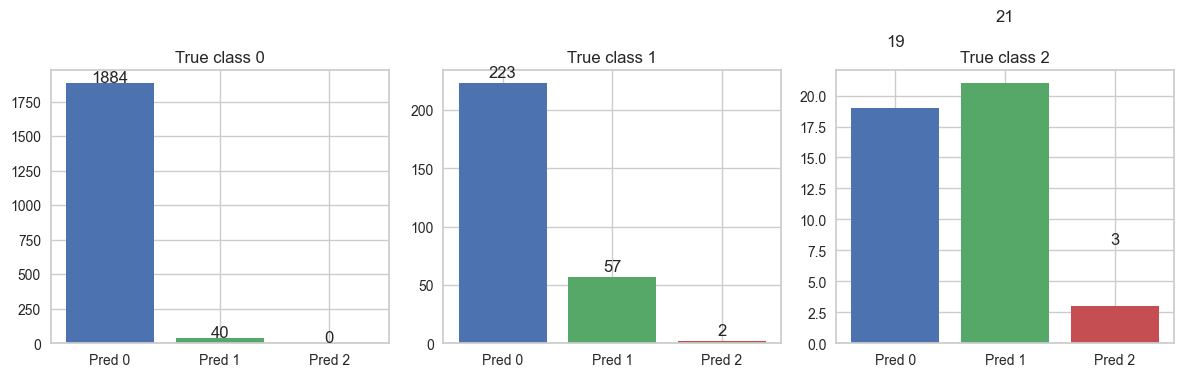

In [ ]:
# 시각화
confmat = np.array([[1884, 40, 0],
                    [223, 57, 2],
                    [19, 21, 3]])

classes = [0, 1, 2]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for idx, cls in enumerate(classes):
    # 한 클래스만 뽑아서 시각화
    row = confmat[cls, :]
    ax = axes[idx]
    ax.bar(range(len(classes)), row, color=['#4c72b0', '#55a868', '#c44e52'])
    ax.set_xticks(range(len(classes)))
    ax.set_xticklabels([f"Pred {c}" for c in classes])
    ax.set_title(f"True class {cls}")
    for i, val in enumerate(row):
        ax.text(i, val+5, str(val), ha='center')

plt.tight_layout()
plt.show()


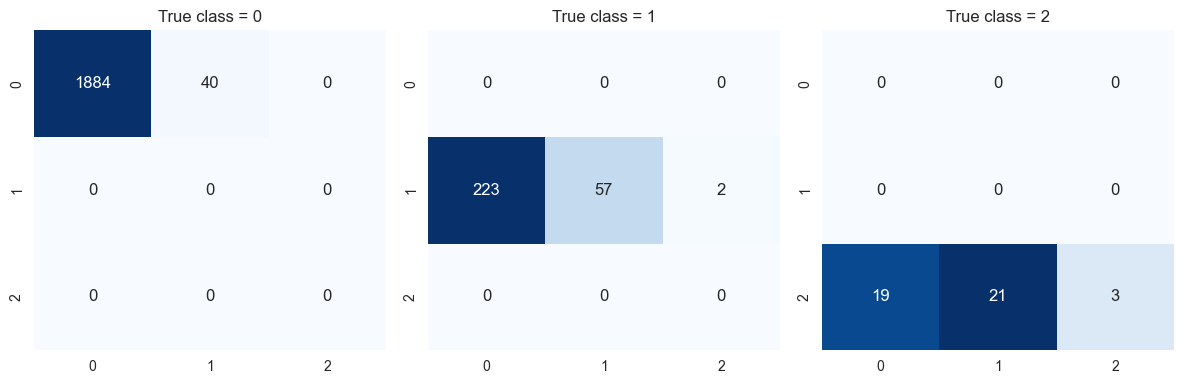

In [ ]:

# 원래 confusion matrix
confmat = np.array([[1884, 40, 0],
                    [223, 57, 2],
                    [19, 21, 3]])

classes = [0, 1, 2]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for idx, cls in enumerate(classes):
    # 해당 클래스 행(row)만 추출
    row = np.zeros_like(confmat)
    row[cls, :] = confmat[cls, :]
    
    sns.heatmap(row, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=classes, yticklabels=classes, ax=axes[idx])
    axes[idx].set_title(f"True class = {cls}")

plt.tight_layout()
plt.show()


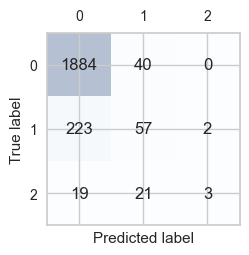

In [ ]:
# confusion_matrix로
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap = plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x = j, y = i, s = confmat[i, j], va = 'center', ha = 'center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

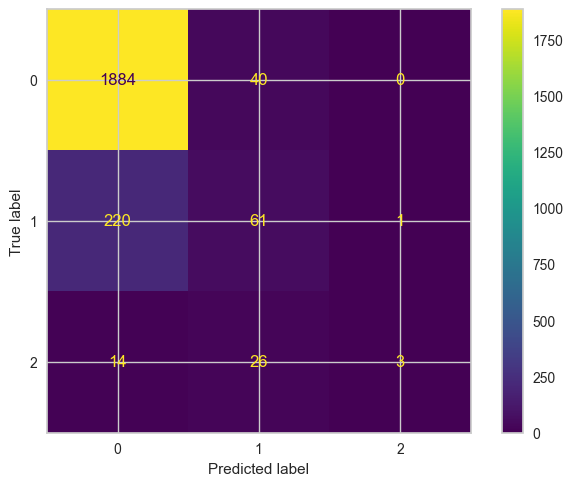

In [ ]:
# 테스트 데이터로
ConfusionMatrixDisplay.from_estimator(pipe_lr, X_test, y_test)
plt.show()

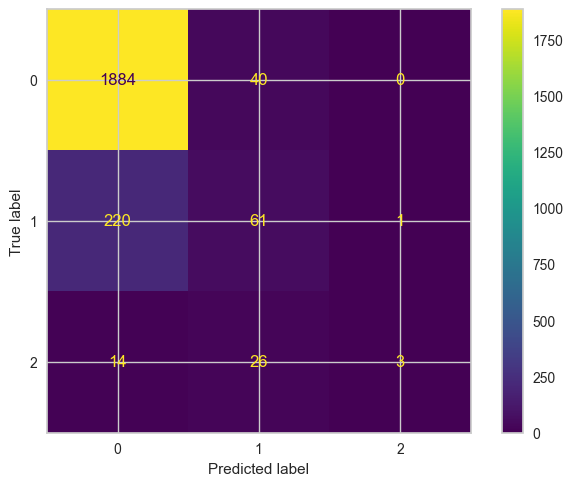

In [ ]:
# 실제값, 분류값으로
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

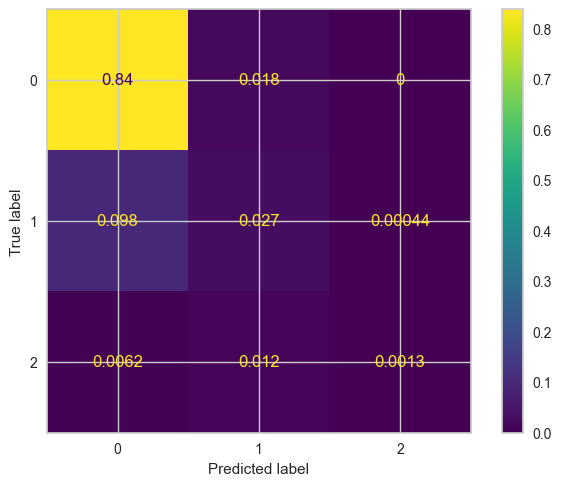

In [ ]:
# 비율로 확인하기
ConfusionMatrixDisplay.from_estimator(pipe_lr, X_test, y_test,
                                      normalize = 'all')
plt.savefig('./confusion_matrix_normalize.png', dpi=300)
plt.show()

In [ ]:
### Matrics 'macro'

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# y_test, y_pred가 이미 있다고 가정
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1-score (macro):", f1_score(y_test, y_pred, average='macro'))

# 클래스별 상세 리포트
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.866162738995109
Precision (macro): 0.7066111247425516
Recall (macro): 0.42176315926934427
F1-score (macro): 0.4527199531246282

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.98      0.93      1924
           1       0.48      0.22      0.30       282
           2       0.75      0.07      0.13        43

    accuracy                           0.87      2249
   macro avg       0.71      0.42      0.45      2249
weighted avg       0.84      0.87      0.84      2249



In [ ]:
### 불균형한 클래스 오버 샘플링

from sklearn.utils import resample

# 클래스 0과 1의 샘플 수 확인
print('샘플링 전 클래스 0 샘플 수:', y_train[y_train == 0].shape[0])
print('샘플링 전 클래스 1 샘플 수:', y_train[y_train == 1].shape[0])
print('샘플링 전 클래스 2 샘플 수:', y_train[y_train == 2].shape[0])

# 클래스 0과 1 분리
X_train_0 = X_train[y_train == 0]
y_train_0 = y_train[y_train == 0]

X_train_1 = X_train[y_train == 1]
y_train_1 = y_train[y_train == 1]

X_train_2 = X_train[y_train == 2]
y_train_2 = y_train[y_train == 2]

# 다수 클래스 크기에 맞춰 목표 샘플 수 설정(여기선 0번 크기)
target_n = len(y_train_0)



# 1번, 2번 오버샘플링
X_train_1_upsampled, y_train_1_upsampled = resample(
    X_train_1, y_train_1, replace=True, n_samples=target_n, random_state=42
)
X_train_2_upsampled, y_train_2_upsampled = resample(
    X_train_2, y_train_2, replace=True, n_samples=target_n, random_state=42
)

# 합치기 (0 + 1_up + 2_up)
X_train_balanced = np.vstack((X_train_0, X_train_1_upsampled, X_train_2_upsampled))
y_train_balanced = np.hstack((y_train_0, y_train_1_upsampled, y_train_2_upsampled))

# 확인
print('샘플링 후 클래스 0:', np.sum(y_train_balanced == 0))
print('샘플링 후 클래스 1:', np.sum(y_train_balanced == 1))
print('샘플링 후 클래스 2:', np.sum(y_train_balanced == 2))

샘플링 전 클래스 0 샘플 수: 7693
샘플링 전 클래스 1 샘플 수: 1129
샘플링 전 클래스 2 샘플 수: 172
샘플링 후 클래스 0: 7693
샘플링 후 클래스 1: 7693
샘플링 후 클래스 2: 7693


In [ ]:
# X_train_balanced, y_train_balanced 는 네가 만든 오버샘플링 결과 (0+1_up+2_up)

# 만약 ColumnTransformer가 DataFrame을 기대한다면 컬럼 유지
if isinstance(X_train, pd.DataFrame):
    # 컬럼 개수 불일치 시, 앞에서 사용한 feature 리스트로 맞추기
    if X_train_balanced.shape[1] == len(X_train.columns):
        X_train_balanced_df = pd.DataFrame(X_train_balanced, columns=X_train.columns)
    else:
        # 컬럼 개수 맞는 부분만 사용 (예: selected_features 등)
        # 아래 selected_features는 실제 사용한 feature 리스트로 교체
        X_train_balanced_df = pd.DataFrame(X_train_balanced, columns=X_train.columns[:X_train_balanced.shape[1]])
else:
    X_train_balanced_df = X_train_balanced  # 이미 ndarray면 그대로

# 전처리 + 모델 파이프라인 (예시: preprocess 는 ColumnTransformer)
from lightgbm import LGBMClassifier
clf = Pipeline(steps=[
    ('pre', preprocess),                          # 수치/범주 impute + OHE 등
    ('model', LGBMClassifier(random_state=42))
])

# ⬇️ 오버샘플링된 train으로 학습
clf.fit(X_train_balanced_df, y_train_balanced)

# ⬇️ 원본 test로 예측 (절대 test는 오버샘플링 X)
y_pred = clf.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1133
[LightGBM] [Info] Number of data points in the train set: 23079, number of used features: 350
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


Confusion Matrix (counts)
 [[1739  180    5]
 [  99  167   16]
 [   6   19   18]]


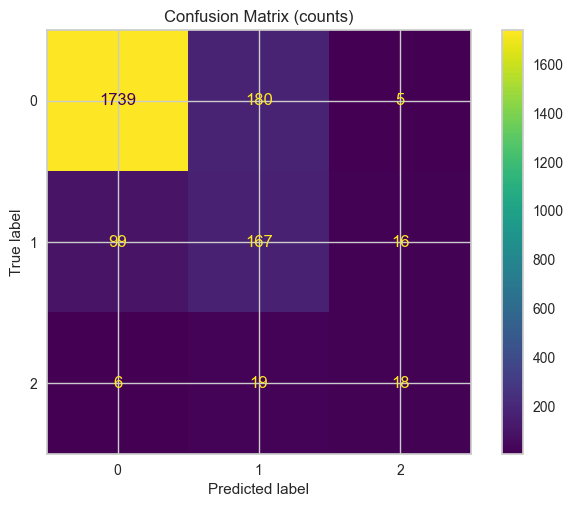

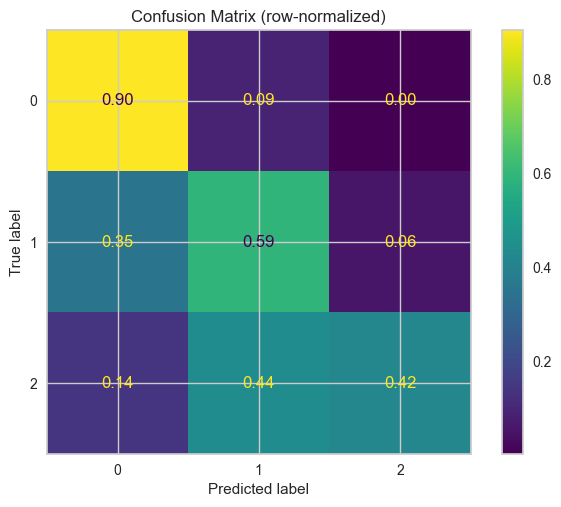

In [ ]:
# 라벨 순서를 고정하고 싶으면 labels=[0,1,2] 지정
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_train))
print("Confusion Matrix (counts)\n", cm)

# 시각화 (matplotlib)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
disp.plot(values_format='d')
plt.title("Confusion Matrix (counts)")
plt.show()

# 비율로도 보고 싶다면 (행 기준 정규화: 실제 클래스별 정확 분포)
cm_norm = confusion_matrix(y_test, y_pred, labels=np.unique(y_train), normalize='true')
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=np.unique(y_train))
disp2.plot(values_format='.2f')
plt.title("Confusion Matrix (row-normalized)")
plt.show()


In [ ]:
print("\nClassification report (macro avg 강조)")
print(classification_report(y_test, y_pred, digits=3))

# 직접 f1 비교
from sklearn.metrics import f1_score
print("F1 macro   :", f1_score(y_test, y_pred, average='macro'))
print("F1 weighted:", f1_score(y_test, y_pred, average='weighted'))



Classification report (macro avg 강조)
              precision    recall  f1-score   support

           0      0.943     0.904     0.923      1924
           1      0.456     0.592     0.515       282
           2      0.462     0.419     0.439        43

    accuracy                          0.855      2249
   macro avg      0.620     0.638     0.626      2249
weighted avg      0.873     0.855     0.863      2249

F1 macro   : 0.6258308608091978
F1 weighted: 0.8626728965625033


In [ ]:
# -----------------------------
feature 이름 뽑기
# -----------------------------
def get_feature_names(preprocessor, num_cols, cat_cols):
    feature_names = []
    # 수치
    feature_names.extend(num_cols)
    # 범주
    ohe = preprocessor.named_transformers_['cat'].named_steps['ohe']
    cat_feature_names = ohe.get_feature_names_out(cat_cols).tolist()
    feature_names.extend(cat_feature_names)
    return feature_names

# Ensure the pipeline is fitted before extracting feature names
if not hasattr(clf.named_steps['pre'], 'named_transformers_'):
    # Fit with some data (X_train or similar)
    clf.fit(X_train, y_train)

final_feature_names = get_feature_names(
    clf.named_steps['pre'], num_cols, cat_cols
)
print("최종 특성 개수:", len(final_feature_names))

최종 특성 개수: 9177


In [ ]:
# -----------------------------
# Feature importance 추출
# -----------------------------
importances = clf.named_steps['model'].feature_importances_

# 길이 맞추기
n = min(len(final_feature_names), len(importances))
feat_imp = pd.DataFrame({
    'feature': final_feature_names[:n],
    'importance': importances[:n]
}).sort_values(by='importance', ascending=False)

print(feat_imp.head(20))   # 상위 20개 중요 피처

              feature  importance
34    emp_boss_gender         806
71        wsituation7         773
72        wsituation8         762
149              who1         704
65         safeinform         688
150              who2         679
68        wsituation5         667
76             wstat3         664
126          wbalance         661
5         wtime_group         628
46            emp_rep         623
77             wstat5         616
12   earning2_group_b         608
127              wwa1         607
75             wstat2         600
147        heal_prob8         600
47       emp_winflu_a         598
164       decla_group         589
74             wstat1         587
3           age_group         581


In [ ]:
import re

# 그룹 매핑 함수 (예: 알파벳/언더바 기준 앞부분만 추출)
def get_group_name(feat):
    # 숫자/인덱스 제거하고 접두사만 추출
    m = re.match(r"([a-zA-Z_]+)", feat)
    if m:
        return m.group(1)
    return feat  # 매칭 안 되면 원래 이름 반환

# 그룹 컬럼 생성
feat_imp["group"] = feat_imp["feature"].apply(get_group_name)

# 그룹별 중요도 합산
group_imp = feat_imp.groupby("group")["importance"].sum().sort_values(ascending=False)

print(group_imp.head(20))


group
wsituation         4688
wstat              3057
who                2909
imte               2184
wwa                1434
heal_prob          1369
woutside            883
condim              834
hazard_erg_a_       824
emp_boss_gender     806
wplace              776
wtime_length        713
safeinform          688
wbalance            661
wtime_group         628
emp_rep             623
earning             608
emp_winflu_a        598
hazard_erg_b_       589
decla_group         589
Name: importance, dtype: int32


In [ ]:
G = 10  # 상위 10개 그룹
group_imp = (feat_imp.groupby("group")["importance"]
             .sum().sort_values(ascending=False))
selected_groups = set(group_imp.head(G).index)
print("선택된 그룹:", selected_groups)


선택된 그룹: {'wsituation', 'heal_prob', 'imte', 'wstat', 'hazard_erg_a_', 'who', 'woutside', 'emp_boss_gender', 'wwa', 'condim'}


In [ ]:
alpha = 0.80  # 누적 80%까지
gi = (feat_imp.groupby("group")["importance"]
      .sum().sort_values(ascending=False))
cum = gi.cumsum() / gi.sum()
selected_groups = set(cum[cum <= alpha].index)
print("선택된 그룹(누적 80%):", selected_groups)


선택된 그룹(누적 80%): {'hazard_erg_d', 'decla_group', 'emp_manaqual_d', 'occ_t', 'emp_comp_ass_c', 'hazard_erg_c', 'wplace', 'income_bal', 'emp_comp_ass_d', 'emp_winflu_a', 'wstat', 'who', 'woutside', 'emp_boss_gender', 'emp_winflu_b', 'wteam', 'emp_manaqual_c', 'earning', 'wtime_group', 'wtime_private', 'comp_female', 'age_group', 'heal_prob', 'hazard_erg_a_', 'decla_c', 'emp_manaqual_a', 'emp_comp_ass_a', 'emp_manaqual_b', 'wbalance', 'wsituation', 'wtime_length', 'income_con', 'imte', 'wtime_ftwork', 'hazard_erg_b_', 'sleep', 'emp_comp_ass_b', 'wwa', 'condim', 'safeinform', 'emp_rep', 'asb'}


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 470
[LightGBM] [Info] Number of data points in the train set: 8994, number of used features: 100
[LightGBM] [Info] Start training from score -0.156247
[LightGBM] [Info] Start training from score -2.075225
[LightGBM] [Info] Start training from score -3.956818
Selected groups: {'hazard_erg_d', 'decla_group', 'emp_manaqual_d', 'occ_t', 'emp_comp_ass_c', 'hazard_erg_c', 'wplace', 'income_bal', 'emp_comp_ass_d', 'emp_winflu_a', 'wstat', 'who', 'woutside', 'emp_boss_gender', 'emp_winflu_b', 'wteam', 'emp_manaqual_c', 'earning', 'wtime_group', 'wtime_private', 'comp_female', 'age_group', 'heal_prob', 'hazard_erg_a_', 'decla_c', 'emp_manaqual_a', 'emp_comp_ass_a', 'emp_manaqual_b', 'wbalance', 'wsituation', 'wtime_length', 'income_con', 'imte', 'wtime_ftwork', 'hazard_erg_b_', 'sleep', 'emp_comp_ass_b', 'w

In [ ]:
# # (옵션1) 선택 그룹의 모든 피처 사용
# selected_features = (feat_imp
#     .loc[feat_imp["group"].isin(selected_groups)]
#     .sort_values("importance", ascending=False)["feature"].tolist())

# (옵션2) 선택 그룹 내에서 각 그룹별 상위 m개만 사용
m = 5
selected_features = (feat_imp.sort_values("importance", ascending=False)
    .loc[feat_imp["group"].isin(selected_groups)]
    .groupby("group").head(m)["feature"].tolist())

# 전처리 통과한 행렬에서 해당 컬럼만 슬라이싱
Xtr_trans = pipe_model.named_steps['pre'].transform(X_train)
Xte_trans = pipe_model.named_steps['pre'].transform(X_test)
Xtr_df = pd.DataFrame(Xtr_trans, columns=final_feature_names)
Xte_df = pd.DataFrame(Xte_trans, columns=final_feature_names)

# 혹시 선택 목록에 전처리 컬럼에 없는 이름이 섞였을 때 교집합으로 안전하게
selected_features = [c for c in selected_features if c in Xtr_df.columns]

Xtr_sel = Xtr_df[selected_features].values
Xte_sel = Xte_df[selected_features].values

# 새 모델로 재학습/평가
model_sel = LGBMClassifier(n_estimators=500, learning_rate=0.05, random_state=42)
model_sel.fit(Xtr_sel, y_train)
y_pred = model_sel.predict(Xte_sel)

print("Selected groups:", selected_groups)
print("Selected features:", len(selected_features))
print("Test F1(macro):",
      f1_score(y_test, y_pred, average='macro'))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 421
[LightGBM] [Info] Number of data points in the train set: 8994, number of used features: 87
[LightGBM] [Info] Start training from score -0.156247
[LightGBM] [Info] Start training from score -2.075225
[LightGBM] [Info] Start training from score -3.956818
Selected groups: {'hazard_erg_d', 'decla_group', 'emp_manaqual_d', 'occ_t', 'emp_comp_ass_c', 'hazard_erg_c', 'wplace', 'income_bal', 'emp_comp_ass_d', 'emp_winflu_a', 'wstat', 'who', 'woutside', 'emp_boss_gender', 'emp_winflu_b', 'wteam', 'emp_manaqual_c', 'earning', 'wtime_group', 'wtime_private', 'comp_female', 'age_group', 'heal_prob', 'hazard_erg_a_', 'decla_c', 'emp_manaqual_a', 'emp_comp_ass_a', 'emp_manaqual_b', 'wbalance', 'wsituation', 'wtime_length', 'income_con', 'imte', 'wtime_ftwork', 'hazard_erg_b_', 'sleep', 'emp_comp_ass_b', 'ww

In [ ]:
from sklearn.model_selection import cross_validate
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(random_state=42)


In [ ]:
### Feature Selection - Embedded 방식 ###
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

In [ ]:
# ----- 데이터 분리 (예시) -----
# df: 전처리 전 데이터프레임, target 컬럼명은 'burnout60'이라고 가정
X = df_new.drop(columns=['burnout60'], errors='ignore')
y = df_new['burnout60']

In [ ]:
# 학습/검증 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
# ----- 컬럼 타입 구분 -----
num_cols = X_train.select_dtypes(include=[np.number, 'bool']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()


In [ ]:
# ----- 전처리 파이프라인 -----
# 수치: 평균 대치 → 그대로
num_tf = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])


In [ ]:
# 범주: 최빈 대치 → 원핫 (미지정 카테고리 무시)
cat_tf = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', num_tf, num_cols),
        ('cat', cat_tf, cat_cols),
    ],
    remainder='drop'
)

In [ ]:
# ----- 모델 -----
lgbm = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    random_state=42
)

In [ ]:

# ----- 전체 파이프라인 (전처리 → LGBM) -----
pipe_model = Pipeline(steps=[
    ('pre', preprocess),
    ('model', lgbm)
])


In [ ]:
# ----- 원핫 이후 최종 피처 이름 추출 -----
def get_final_feature_names(preprocessor, num_cols, cat_cols):
    feature_names = []
    # 수치 파이프라인은 이름 그대로
    feature_names.extend(num_cols)

In [ ]:
# ----- SelectFromModel: 중요도 기준 피처 선택 -----
selector = SelectFromModel(
    estimator=pipe_model.named_steps['model'],
    threshold='median',     # 'mean' 또는 수치(예: 0.001)로 조절 가능
    prefit=True
)

In [ ]:
# 먼저 ColumnTransformer를 fit해야 transform이 가능합니다.
# pd.NA → np.nan 변환 (파이프라인에서 처리 가능하게)
X_train_clean = X_train.replace({pd.NA: np.nan})
X_test_clean  = X_test.replace({pd.NA: np.nan})

pipe_model.named_steps['pre'].fit(X_train_clean)

X_train_trans = pipe_model.named_steps['pre'].transform(X_train_clean)
X_test_trans  = pipe_model.named_steps['pre'].transform(X_test_clean)

# Fit the model before using SelectFromModel with prefit=True
pipe_model.named_steps['model'].fit(X_train_trans, y_train)

# Use the same selector instance for both train and test
selector = SelectFromModel(
	estimator=pipe_model.named_steps['model'],
	threshold='median',
	prefit=True
)

X_train_sel = selector.transform(X_train_trans)
X_test_sel  = selector.transform(X_test_trans)

# Ensure X_test_sel has the same number of features as X_train_sel
assert X_train_sel.shape[1] == X_test_sel.shape[1], \
	f"Train and test feature mismatch: {X_train_sel.shape[1]} vs {X_test_sel.shape[1]}"

# Refit the model using only the selected features
sel_model = LGBMClassifier(
	n_estimators=500,
	learning_rate=0.05,
	random_state=42
)
sel_model.fit(X_train_sel, y_train)

# Predict using the model trained on selected features
y_pred_sel = sel_model.predict(X_test_sel)

ValueError: X has 9178 features, but LGBMClassifier is expecting 12148 features as input.

In [ ]:
# ----- 원핫 이후 최종 피처 이름 추출 -----
def get_final_feature_names(preprocessor, num_cols, cat_cols):
	feature_names = []
	# 수치 파이프라인은 이름 그대로
	feature_names.extend(num_cols)
	# 범주형 파이프라인은 원핫 인코더에서 추출
	cat_ohe = preprocessor.named_transformers_['cat'].named_steps['ohe']
	cat_feature_names = cat_ohe.get_feature_names_out(cat_cols)
	feature_names.extend(cat_feature_names)
	return feature_names

final_feature_names = get_final_feature_names(preprocess, num_cols, cat_cols)

# ----- 선택된 피처 이름 추출 -----
mask = selector.get_support()
selected_features = [f for f, m in zip(final_feature_names, mask) if m]

print("원핫 후 전체 피처 수:", len(final_feature_names))
print("선택된 피처 수:", len(selected_features))
print("선택된 피처 샘플:", selected_features[:20])


원핫 후 전체 피처 수: 12148
선택된 피처 수: 12148
선택된 피처 샘플: ['area', 'gender', 'wtime_length5', 'age_group', 'emp_period_group', 'wtime_group', 'compsize_group', 'woutside_group', 'compsize_group_a', 'wday_week_group_a', 'woutside4_group_a', 'occ_t2_group_a', 'earning2_group_b', 'occ_group_a', 'emp_stat', 'emp_con_term', 'emp_keep', 'emp_own_mgmt', 'emp_fptime', 'emp_wage']


In [ ]:
# 2) Embedded Feature Selection
# Use final_feature_names and selector mask to get selected feature names
selected_mask = selector.get_support()
selected_cols = [f for f, m in zip(final_feature_names, selected_mask) if m]

# Ensure missing values are np.nan (not pd.NA) before transformation
# Add missing columns with np.nan before reindexing
# Ensure all columns required by the preprocessor exist in X_train and X_val
required_cols = set(final_feature_names) | {'id', 'hazard_erg_a', 'hazard_erg_b', 'ctime_group'}
missing_cols_train = required_cols - set(X_train.columns)
missing_cols_val = required_cols - set(X_val.columns)

for col in missing_cols_train:
	X_train[col] = np.nan
for col in missing_cols_val:
	X_val[col] = np.nan

X_train_clean = X_train.replace({pd.NA: np.nan}).reindex(columns=list(required_cols))
X_val_clean   = X_val.replace({pd.NA: np.nan}).reindex(columns=list(required_cols))

# Transform X_train and X_val using the preprocessor
X_train_trans = preprocess.transform(X_train_clean)
X_val_trans   = preprocess.transform(X_val_clean)

# Convert to DataFrame with correct feature names
import pandas as pd
X_train_sel_df = pd.DataFrame(X_train_trans, columns=final_feature_names)[selected_cols].copy()
X_val_sel_df   = pd.DataFrame(X_val_trans, columns=final_feature_names)[selected_cols].copy()

print(f"\n선택된 특성 개수: {len(selected_cols)} / {len(final_feature_names)}")
print("선택된 특성 리스트:", selected_cols)


선택된 특성 개수: 12148 / 12148
선택된 특성 리스트: ['area', 'gender', 'wtime_length5', 'age_group', 'emp_period_group', 'wtime_group', 'compsize_group', 'woutside_group', 'compsize_group_a', 'wday_week_group_a', 'woutside4_group_a', 'occ_t2_group_a', 'earning2_group_b', 'occ_group_a', 'emp_stat', 'emp_con_term', 'emp_keep', 'emp_own_mgmt', 'emp_fptime', 'emp_wage', 'emp_stat_sp', 'income_pos_a', 'income_pos_b', 'income_pos_c', 'income_pos_d', 'income_pos_e', 'income_pos_f', 'income_pos_g', 'income_pos_h', 'income_pos_i', 'income_pos_j', 'emp_place', 'emp_suggest_a', 'emp_suggest_b', 'emp_boss_gender', 'emp_manaqual_a', 'emp_manaqual_b', 'emp_manaqual_c', 'emp_manaqual_d', 'emp_manaqual_e', 'emp_comp_ass_a', 'emp_comp_ass_b', 'emp_comp_ass_c', 'emp_comp_ass_d', 'emp_comp_ass_e', 'emp_comp_ass_f', 'emp_rep', 'emp_winflu_a', 'emp_winflu_b', 'emp_winflu_c', 'emp_tra_b', 'emp_tra_c', 'emp_tra_d', 'wsector', 'comp_size_a', 'comp_female', 'comp_sjob', 'ch_tech', 'ch_me', 'ch_ps', 'imte1', 'imte2', 'imte3'

In [ ]:
# 기존 선택된 피처
mask = selector.get_support()
selected_features = [f for f, m in zip(final_feature_names, mask) if m]

# 특정 피처 제외하기
exclude_cols = ['area']   # 뺄 컬럼 리스트
selected_features = [f for f in selected_features if f not in exclude_cols]

print("최종 선택된 피처 수:", len(selected_features))
print("최종 선택된 피처 샘플:", selected_features[:20])


최종 선택된 피처 수: 12147
최종 선택된 피처 샘플: ['gender', 'wtime_length5', 'age_group', 'emp_period_group', 'wtime_group', 'compsize_group', 'woutside_group', 'compsize_group_a', 'wday_week_group_a', 'woutside4_group_a', 'occ_t2_group_a', 'earning2_group_b', 'occ_group_a', 'emp_stat', 'emp_con_term', 'emp_keep', 'emp_own_mgmt', 'emp_fptime', 'emp_wage', 'emp_stat_sp']


In [ ]:
# 3) 선택된 특성으로 재학습
sel_model = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    random_state=42
)
sel_model.fit(X_train_sel_df, y_train)

y_pred_sel = sel_model.predict(X_val_sel_df)

acc_sel = accuracy_score(y_val, y_pred_sel)
prec_sel = precision_score(y_val, y_pred_sel, average="weighted")

print("\n=== Selected Features (임베디드 선택) ===")
print(f"Accuracy : {acc_sel:.4f}")
print(f"Precision: {prec_sel:.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 900
[LightGBM] [Info] Number of data points in the train set: 11964, number of used features: 178
[LightGBM] [Info] Start training from score -0.171845
[LightGBM] [Info] Start training from score -1.998859
[LightGBM] [Info] Start training from score -3.798670

=== Selected Features (임베디드 선택) ===
Accuracy : 0.8760
Precision: 0.8587


In [ ]:
from sklearn.metrics import accuracy_score, precision_score

# base model 예측값이 y_pred_base, 실제값이 y_val 또는 y_test라고 가정
# selected features 예측값이 y_pred_sel, 실제값이 y_val 또는 y_test

# base model 성능 계산 (예시: y_pred_base, y_val 사용)
# Ensure y_pred_base and y_val have the same length

# 1. y_val을 숫자형으로 변환 (lv1→0, lv2→1, lv3→2)
label_map = {"lv1": 0, "lv2": 1, "lv3": 2}
y_val_num = y_val.map(label_map)

# 2. y_pred_base도 숫자형이어야 함 (이미 숫자면 그대로 사용)
acc_base = accuracy_score(y_val_num, y_pred_base[:len(y_val_num)])
prec_base = precision_score(y_val_num, y_pred_base[:len(y_val_num)], average="weighted")

# 이미 selected features 성능은 acc_sel, prec_sel로 계산됨

# 4) 성능 비교 표
summary = pd.DataFrame({
    "metric": ["Accuracy", "Precision"],
    "All features": [acc_base, prec_base],
    "Selected features": [acc_sel, prec_sel]
})
print("\n=== 성능 비교 ===")
print(summary)



=== 성능 비교 ===
      metric  All features  Selected features
0   Accuracy      0.738971           0.876003
1  Precision      0.725162           0.858716


In [ ]:
### 시각화
# 1) 중요도 테이블 만들기 (선택됨/제외됨 표시)

# 학습된 모델의 중요도 정리 (LightGBM의 전체 특성 중요도)
imp_df = pd.DataFrame({
    "feature": final_feature_names,
    "importance": lgbm.feature_importances_.astype(float)
}).sort_values("importance", ascending=False)

# 선택 여부 컬럼 추가
support_mask = selector.get_support()
imp_df["selected"] = support_mask

# 중요도 정규화(퍼센트)
imp_df["importance_pct"] = 100 * imp_df["importance"] / (imp_df["importance"].sum() + 1e-12)

imp_df.head(10)


,feature,importance,selected,importance_pct
0,area,1090.0,True,2.422222
73,wsituation13,757.0,True,1.682222
69,wsituation11,755.0,True,1.677778
72,wsituation8,747.0,True,1.660000
35,emp_manaqual_a,710.0,True,1.577778
165,winten2_group,657.0,True,1.460000
13,occ_group_a,653.0,True,1.451111
66,wsituation3,645.0,True,1.433333
6,compsize_group,634.0,True,1.408889
77,wstat5,630.0,True,1.400000


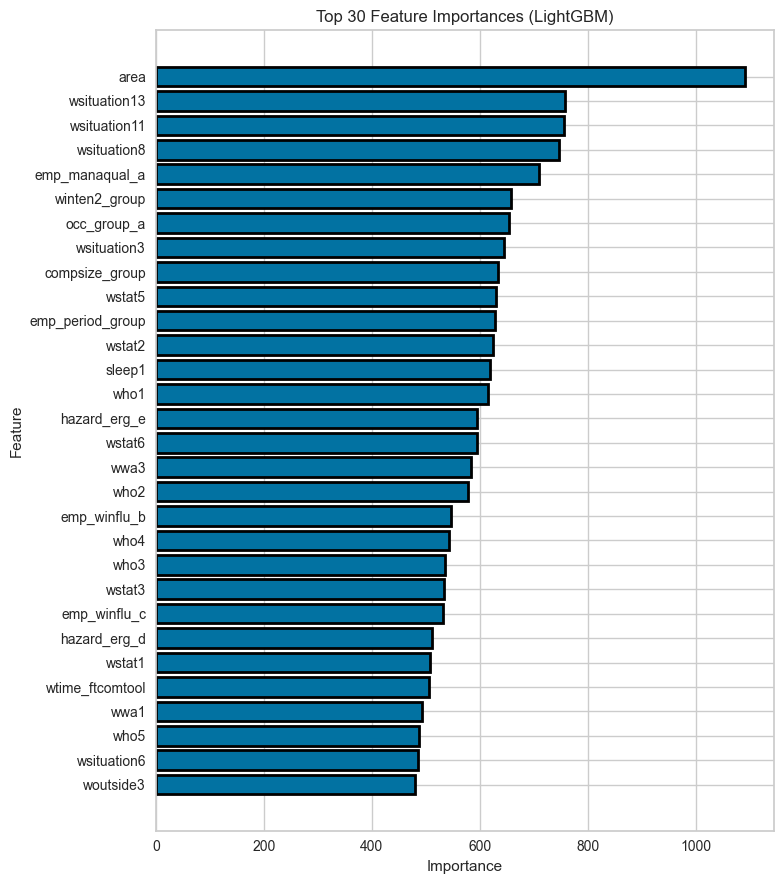

In [ ]:
# 2) 상위 N개 중요도 막대 그래프 (선택된 특성 하이라이트)

import matplotlib.pyplot as plt

N = 30  # 상위 몇 개를 볼지
top = imp_df.head(N).iloc[::-1]  # barh는 뒤집어 주면 보기 좋아짐

plt.figure(figsize=(8, max(6, N*0.3)))
bars = plt.barh(top["feature"], top["importance"])

# 선택된 특성은 두께/외곽선으로 하이라이트
for i, sel in enumerate(top["selected"]):
    if sel:
        bars[i].set_linewidth(2.0)
        bars[i].set_edgecolor("black")  # matplotlib 기본 팔레트 내 색 사용
    else:
        bars[i].set_alpha(0.5)

plt.title(f"Top {N} Feature Importances (LightGBM)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


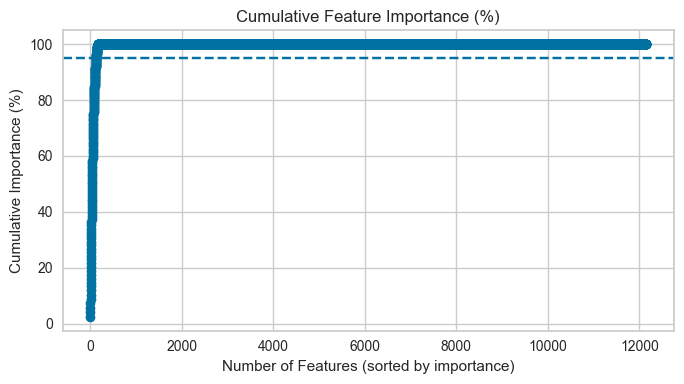

In [ ]:
# 3) 누적 중요도 그래프 (얼마나 줄여도 되는지 감 잡기)

cum = imp_df.copy()
cum["cum_importance_pct"] = cum["importance_pct"].cumsum()

plt.figure(figsize=(7,4))
plt.plot(np.arange(1, len(cum)+1), cum["cum_importance_pct"], marker="o")
plt.axhline(95, linestyle="--")  # 95% 선
plt.title("Cumulative Feature Importance (%)")
plt.xlabel("Number of Features (sorted by importance)")
plt.ylabel("Cumulative Importance (%)")
plt.tight_layout()
plt.show()


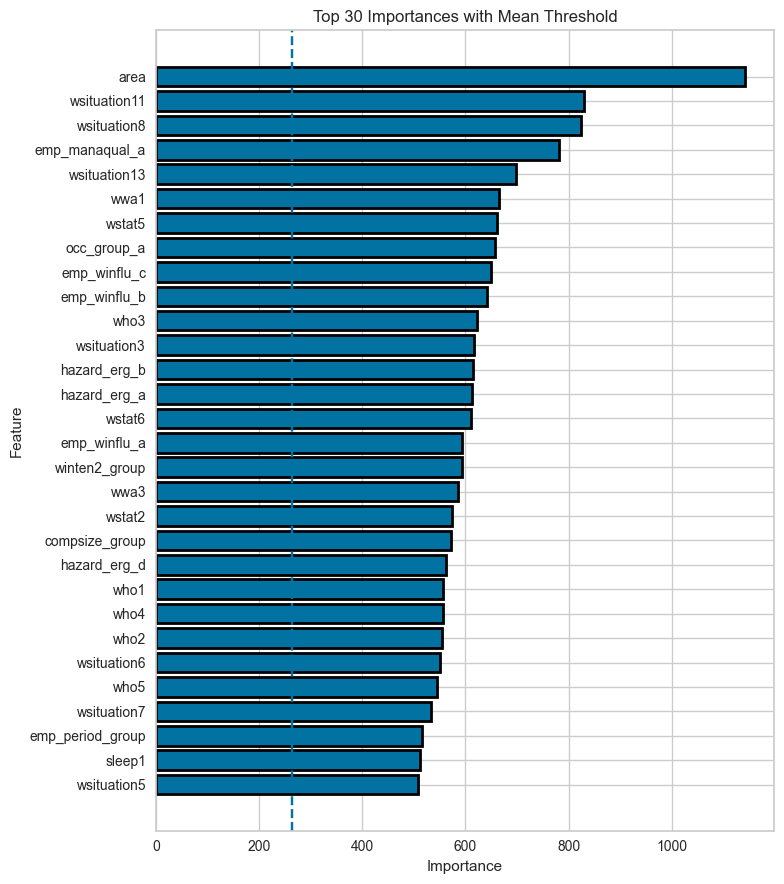

In [ ]:
# 4) 선택 임계값(평균 중요도)과의 비교 시각화

thresh = imp_df["importance"].mean()

plt.figure(figsize=(8, max(6, N*0.3)))
top = imp_df.head(N).iloc[::-1]
bars = plt.barh(top["feature"], top["importance"])

# 평균선
plt.axvline(thresh, linestyle="--")

# 선택된 특성 강조
for i, sel in enumerate(top["selected"]):
    if sel:
        bars[i].set_linewidth(2.0)
        bars[i].set_edgecolor("black")
    else:
        bars[i].set_alpha(0.5)

plt.title(f"Top {N} Importances with Mean Threshold")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


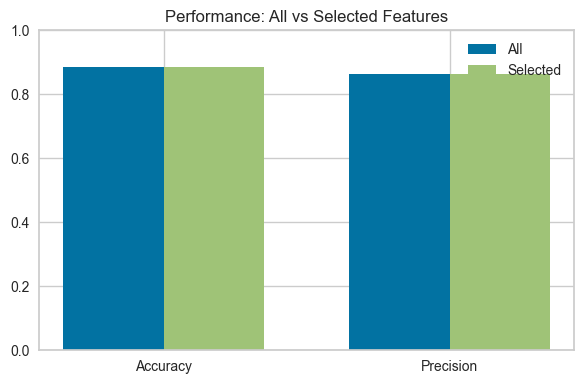

In [ ]:
# 5) 선택 전/후 성능 및 특성 수 비교(요약 바차트)

# 이미 이전 단계에서 계산했을 것으로 가정:
# acc_base, prec_base, acc_sel, prec_sel

labels = ["Accuracy", "Precision"]
all_features_scores = [acc_base, prec_base]
selected_features_scores = [acc_sel, prec_sel]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(6,4))
plt.bar(x - width/2, all_features_scores, width, label="All")
plt.bar(x + width/2, selected_features_scores, width, label="Selected")
plt.xticks(x, labels)
plt.ylim(0, 1.0)
plt.title("Performance: All vs Selected Features")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# 선택된 특성만 따로 보기 (표/리스트)

selected_only = imp_df[imp_df["selected"]].copy().sort_values("importance", ascending=False)
print("선택된 특성 개수:", selected_only.shape[0])
selected_only.head(20)


선택된 특성 개수: 70


,feature,importance,selected,importance_pct
1,area,1141.0,True,2.535556
70,wsituation11,829.0,True,1.842222
73,wsituation8,824.0,True,1.831111
36,emp_manaqual_a,781.0,True,1.735556
74,wsituation13,698.0,True,1.551111
130,wwa1,666.0,True,1.480000
78,wstat5,662.0,True,1.471111
14,occ_group_a,658.0,True,1.462222
50,emp_winflu_c,650.0,True,1.444444
49,emp_winflu_b,641.0,True,1.424444


In [ ]:
!pip install shap


In [ ]:

# 설명할 데이터 (선택된 특성만)
X_val_used = X_val[selected_cols].copy()

# LightGBM용 TreeExplainer
explainer = shap.TreeExplainer(sel_model)

# 큰 데이터면 샘플링(속도/가독성)
N = min(2000, len(X_val_used))
idx = np.random.RandomState(42).choice(len(X_val_used), N, replace=False)
X_val_sample = X_val_used.iloc[idx]

# SHAP 값 계산
# (경고 억제를 원하면 check_additivity=False 사용 가능)
shap_values = explainer.shap_values(X_val_sample)


In [ ]:
# 다중/이진 자동 분기
is_multiclass = isinstance(shap_values, list)

if is_multiclass:
    # 클래스별 SHAP 배열을 쓴다. (예: 평균 절댓값 최대 클래스, 또는 특정 클래스 선택)
    # 1) 평균 절댓값이 가장 큰 클래스를 대표로 시각화 (전반적 경향 확인용)
    mean_abs = [np.abs(v).mean() for v in shap_values]
    target_class = int(np.argmax(mean_abs))
    sv_for_plot = shap_values[target_class]
    class_info = f"(multi-class, class={target_class})"
else:
    sv_for_plot = shap_values
    class_info = "(binary)"


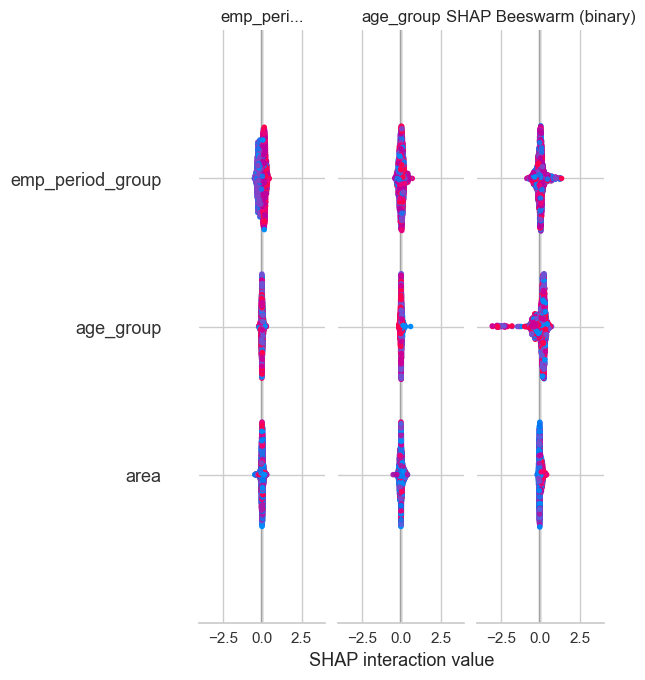

In [ ]:
# Beeswarm (개별 샘플 분포 + 영향)

shap.summary_plot(sv_for_plot, X_val_sample, show=False)
import matplotlib.pyplot as plt
plt.title(f"SHAP Beeswarm {class_info}")
plt.show()


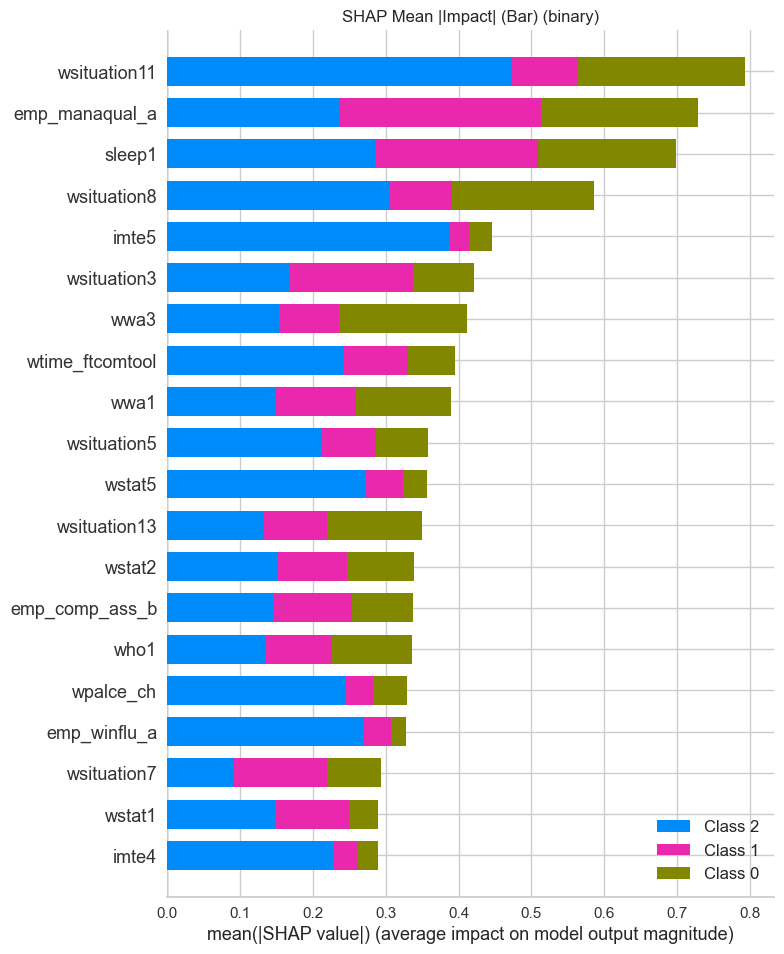

In [ ]:
# Bar (평균 절댓값 중요도)

shap.summary_plot(sv_for_plot, X_val_sample, plot_type="bar", show=False)
import matplotlib.pyplot as plt
plt.title(f"SHAP Mean |Impact| (Bar) {class_info}")
plt.show()


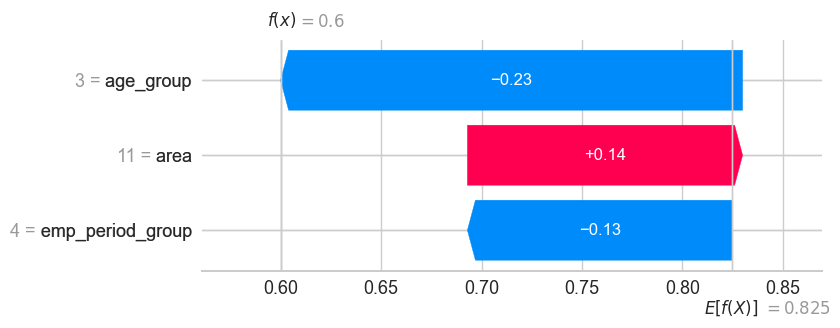

In [ ]:
# 하나의 인스턴스 Waterfall 

i = 0              # 샘플 인덱스
target_class = 0   # 분석할 클래스 인덱스 지정

ex = shap.Explanation(
    values = shap_values[target_class][i],           # 선택 클래스의 shap 값
    base_values = explainer.expected_value[target_class], # 선택 클래스의 expected value (스칼라)
    data = X_val_sample.iloc[i],
    feature_names = X_val_sample.columns
)

shap.plots.waterfall(ex, max_display=20)


In [ ]:
### feature selection + shap

import shap
import re
from scipy import sparse

In [ ]:
# 함수 호출 전에 딱 2줄만 추가
import numpy as np, pandas as pd
X_train = X_train.replace({pd.NA: np.nan})  # NAType → np.nan


In [ ]:
def build_preprocess(X):
    num_cols = X.select_dtypes(include=[np.number, 'bool']).columns.tolist()
    cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    pre = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', num_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
        ]
    )
    return pre, num_cols, cat_cols

def get_feature_names(pre, num_cols, cat_cols):
    # ColumnTransformer + OneHotEncoder의 출력 이름
    # scikit-learn 1.0+ 에서 제공
    names = []
    # 숫자 특성: 'num__col'
    names += [f'num__{c}' for c in num_cols]
    # 범주 특성: 'cat__원본특성=카테고리'
    if len(cat_cols) > 0:
        ohe = pre.named_transformers_['cat']
        ohe_names = ohe.get_feature_names_out(cat_cols).tolist()
        names += [f'cat__{n}' for n in ohe_names]
    return np.array(names)

def _to_dense(X_mat):
    if sparse.issparse(X_mat):
        return X_mat.toarray()
    return X_mat

def _mean_abs_shap_values(explainer, X_mat):
    # shap_values는 버전에 따라 모양이 다름:
    # - 바이너리: (n_samples, n_features)
    # - 멀티클래스: (n_classes, n_samples, n_features) 또는 (n_samples, n_features, n_classes)
    sv = explainer(X_mat, check_additivity=False).values
    if sv is None:
        # 구버전 API 호환
        sv = explainer.shap_values(X_mat)
    sv = np.asarray(sv)

    if sv.ndim == 2:
        # (n_samples, n_features)
        return np.mean(np.abs(sv), axis=0)
    elif sv.ndim == 3:
        # (n_classes, n_samples, n_features) OR (n_samples, n_features, n_classes)
        # 두 경우를 모두 커버
        if sv.shape[0] < 10 and sv.shape[0] != X_mat.shape[0]:
            # (n_classes, n_samples, n_features) 로 가정
            sv_abs = np.abs(sv)  # (C, N, F)
            sv_abs = sv_abs.mean(axis=1)  # (C, F)
            return sv_abs.mean(axis=0)    # (F,)
        else:
            # (n_samples, n_features, n_classes)
            sv_abs = np.abs(sv).mean(axis=2)  # (N, F)
            return sv_abs.mean(axis=0)        # (F,)
    else:
        raise ValueError(f"Unexpected SHAP shape: {sv.shape}")

def _group_to_original_cols(feature_names, importances):
    """
    OHE된 'cat__col=value'들을 원본 'col' 기준으로 합산.
    또한 'num__col'은 그대로 사용.
    """
    base_names = []
    for name in feature_names:
        # 패턴: 'num__col' 또는 'cat__원본=값'
        m = re.match(r'^(?:num|cat)__(.*)$', name)
        inner = m.group(1) if m else name
        # OHE면 '원본=값' → '원본'으로 축약
        if '=' in inner:
            base_names.append(inner.split('=')[0])
        else:
            base_names.append(inner)
    df = pd.DataFrame({'feature_expanded': feature_names,
                       'base_feature': base_names,
                       'importance': importances})
    grouped = df.groupby('base_feature', as_index=False)['importance'].sum()
    grouped.sort_values('importance', ascending=False, inplace=True)
    grouped['rank'] = np.arange(1, len(grouped)+1)
    return grouped[['base_feature', 'importance', 'rank']]

def shap_feature_selection(
    X, y,
    model=None,
    preprocess=None,
    n_splits=5,
    random_state=42,
    top_k=30,
    group_ohe=True
):
    """
    반환:
      - df_importance_expanded: OHE 포함(확장) 피처 중요도
      - df_importance_grouped: 원본 피처 기준 집계 중요도 (group_ohe=True일 때)
      - selected_features: 최종 선택된 top_k 피처 리스트 (원본 피처 기준)
    """
    if model is None:
        model = LGBMClassifier(random_state=random_state)

    if preprocess is None:
        preprocess, num_cols, cat_cols = build_preprocess(X)
    else:
        # 가능하면 자동 추출 시도
        try:
            num_cols = preprocess.transformers_[0][2]
            cat_cols = preprocess.transformers_[1][2]
        except Exception:
            num_cols = X.select_dtypes(include=[np.number, 'bool']).columns.tolist()
            cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # 확장 피처 이름/중요도 누적
    expanded_names_global = None
    expanded_importance_sum = None

    for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
        X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
        X_va, y_va = X.iloc[va_idx], y.iloc[va_idx]

        # 전처리 학습 & 변환
        preprocess_fitted = preprocess.fit(X_tr)
        X_tr_t = _to_dense(preprocess_fitted.transform(X_tr))
        X_va_t = _to_dense(preprocess_fitted.transform(X_va))

        # 확장 피처 이름
        feat_names = get_feature_names(preprocess_fitted, num_cols, cat_cols)
        if expanded_names_global is None:
            expanded_names_global = feat_names

        # 모델 학습 (전처리 결과에 직접 학습)
        clf = LGBMClassifier(random_state=random_state)
        clf.fit(X_tr_t, y_tr)

        # SHAP 설명자
        explainer = shap.TreeExplainer(clf, feature_perturbation="tree_path_dependent")
        imp_fold = _mean_abs_shap_values(explainer, X_va_t)  # (n_features,)

        # 길이 체크 (SHAP-이름 불일치 방지)
        if len(imp_fold) != len(feat_names):
            raise ValueError(f"Mismatch: SHAP features={len(imp_fold)} vs names={len(feat_names)}")

        if expanded_importance_sum is None:
            expanded_importance_sum = np.zeros_like(imp_fold, dtype=float)
        expanded_importance_sum += imp_fold

    # 폴드 평균
    expanded_importance_mean = expanded_importance_sum / n_splits
    df_importance_expanded = pd.DataFrame({
        'feature_expanded': expanded_names_global,
        'importance': expanded_importance_mean
    }).sort_values('importance', ascending=False, ignore_index=True)
    df_importance_expanded['rank'] = df_importance_expanded.index + 1

    if group_ohe:
        df_importance_grouped = _group_to_original_cols(
            df_importance_expanded['feature_expanded'].values,
            df_importance_expanded['importance'].values
        )
        selected_features = df_importance_grouped.head(top_k)['base_feature'].tolist()
        return df_importance_expanded, df_importance_grouped, selected_features
    else:
        selected_features = df_importance_expanded.head(top_k)['feature_expanded'].tolist()
        return df_importance_expanded, None, selected_features

# ================================
# 사용 예시
# ================================
# X_train, y_train 이 준비되어 있다고 가정
# 전처리 자동 구성 + LGBM + 5-Fold CV로 SHAP 기반 중요도 집계
# OHE는 원본 피처로 묶어서(top_k=30) 선택
# df_expanded: OHE 확장 피처별 중요도 / df_grouped: 원본 피처별 중요도
# selected: 최종 선택 피처(원본 기준)
# df_grouped를 보고 top_k 조정하면 됨.

# preprocess, _, _ = build_preprocess(X_train)  # (선택) 직접 만들고 싶으면
# model = LGBMClassifier(random_state=42)       # (선택) 하이퍼파라미터 설정 가능

df_expanded, df_grouped, selected = shap_feature_selection(
    X_train, y_train,
    model=None,
    preprocess=None,
    n_splits=5,
    random_state=42,
    top_k=30,
    group_ohe=True
)

print("▶ 확장 피처 상위 10개")
print(df_expanded.head(10))
print("\n▶ 원본 피처(묶음) 상위 10개")
print(df_grouped.head(10))
print("\n▶ 최종 선택 피처 목록 (top_k):")
print(selected)


TypeError: float() argument must be a string or a real number, not 'NAType'